# <center> 9. Logistic Regression </center>

- Using logistic regression to solve Kaggle problem

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from collections import Counter

from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [1]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

# Kaggle problem
#### https://www.kaggle.com/radmirzosimov/telecom-users-dataset

In [4]:
df = pd.read_csv('data/telecom_users.csv', index_col=0)
df.drop(['customerID'], axis=1, inplace=True)
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
4528,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
6344,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes


In [5]:
df.info()
df.apply(lambda x: x.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object

gender                                                 [Male, Female]
SeniorCitizen                                                  [0, 1]
Partner                                                     [Yes, No]
Dependents                                                  [Yes, No]
tenure              [72, 44, 38, 4, 2, 70, 33, 1, 39, 55, 52, 30, ...
PhoneService                                                [Yes, No]
MultipleLines                             [Yes, No, No phone service]
InternetService                                [No, Fiber optic, DSL]
OnlineSecurity                         [No internet service, No, Yes]
OnlineBackup                           [No internet service, Yes, No]
DeviceProtection                       [No internet service, Yes, No]
TechSupport                            [No internet service, No, Yes]
StreamingTV                            [No internet service, Yes, No]
StreamingMovies                        [No internet service, No, Yes]
Contract            

There are no NA in data, but TotalCharges -- object, lets change that.

In [6]:
df.TotalCharges = df.TotalCharges.replace('', '0.').replace(' ', '0.').astype(float)

In [7]:
X = df.drop('Churn', axis=1)
y = df.Churn.map({'No': 0, 'Yes': 1}).values
X.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1869,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65
4528,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20
6344,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85


Lets add dummy variables and make drop_first=True, to have no multi-collinearity in models.

In [8]:
X = pd.get_dummies(X, drop_first=True)
X.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1869,0,72,24.10,1734.65,1,1,1,1,0,1,...,1,0,1,0,0,1,0,1,0,0
4528,0,44,88.15,3973.20,0,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
6344,1,38,74.95,2869.85,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Dummy classifiers will mark each point by moda of train.

In [10]:
def dummy_classifier(y_train, sz):
    return np.full(sz, Counter(y_train).most_common(1)[0][0])

In [11]:
y_dummy_pred = dummy_classifier(y_train, len(y_test))
print(classification_report(y_test, y_dummy_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1112
           1       0.00      0.00      0.00       385

    accuracy                           0.74      1497
   macro avg       0.37      0.50      0.43      1497
weighted avg       0.55      0.74      0.63      1497



Logistic regression

In [13]:
params_logreg = {
    'C': [0.1, 10, 20, 50, 100, 1000] + list(np.arange(0.25, 5, 0.25))
}
model_logreg = GridSearchCV(
    LogisticRegression(
        max_iter=2000
        , random_state=42
        , penalty='l2'
        , fit_intercept=True
    )
    , params_logreg
    , cv=7
    , verbose=2
    , n_jobs=-3
)
%time model_logreg.fit(X_train, y_train)
model_logreg.best_params_

Fitting 7 folds for each of 25 candidates, totalling 175 fits
Wall time: 7.93 s


GridSearchCV(cv=7, estimator=LogisticRegression(max_iter=2000, random_state=42),
             n_jobs=-3,
             param_grid={'C': [0.1, 10, 20, 50, 100, 1000, 0.25, 0.5, 0.75, 1.0,
                               1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25,
                               3.5, 3.75, 4.0, 4.25, 4.5, 4.75]},
             verbose=2)

{'C': 0.25}

In [14]:
y_logred_pred = model_logreg.predict(X_test)
print(classification_report(y_test, y_logred_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1112
           1       0.64      0.53      0.58       385

    accuracy                           0.80      1497
   macro avg       0.75      0.71      0.73      1497
weighted avg       0.79      0.80      0.80      1497



LogReg is obviously better than dummy classifier.

Lest look at parameters coefficients

<AxesSubplot:>

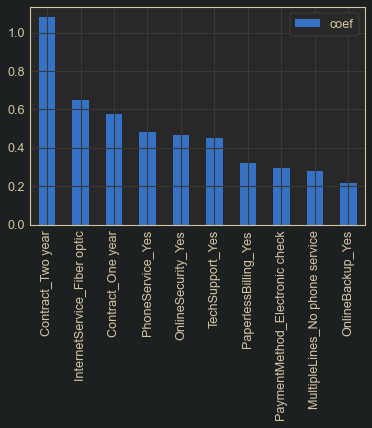

In [16]:
rating = pd.DataFrame(np.abs(model_logreg.best_estimator_.coef_),
                      index=['coef'],
                      columns=X_train.columns.values).transpose().sort_values('coef', ascending=False)
rating[:10].plot.bar()

One must not forget that drop_first=True, and those parameters should be interprered according to that.